## 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
WA


`(2) 기본 라이브러리`

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

## 2. StateGraph
- 상태(state)를 기반으로 작동하는 그래프 구조
- 실습: 레스토랑 메뉴 추천 시스템
    - 사용자의 선호도에 따라 메뉴를 추천하고, 메뉴에 대한 정보를 제공

`(1) 상태(State)`
- 상태는 그래프가 처리하는 데이터의 구조를 정의
- 기존 상태를 override (덮어쓰기)

In [4]:
from typing import TypedDict

# 상태 Schema 정의 - 사용자의 선호도, 추천된 메뉴, 메뉴 정보를 저장
class MenuState(TypedDict):
    user_preference: str
    recommended_menu: str
    menu_info: str

`(2) 노드(Node)`
- 노드는 그래프에서 실제 작업을 수행하는 함수

In [6]:
import random

def get_user_preference(state: MenuState) -> MenuState:
    print("---랜덤 사용자 선호도 생성---")
    preferences = ["육류", "해산물", "채식", "아무거나"]
    preference = random.choice(preferences)
    print(f"생성된 선호도: {preference}")
    return {"user_preference": preference}

def recommend_menu(state: MenuState) -> MenuState:
    print("---메뉴 추천---")
    preference = state['user_preference']
    if preference == "육류":
        menu = "스테이크"
    elif preference == "해산물":
        menu = "랍스터 파스타"
    elif preference == "채식":
        menu = "그린 샐러드"
    else:
        menu = "오늘의 쉐프 특선"
    print(f"추천 메뉴: {menu}")
    return {"recommended_menu": menu}

def provide_menu_info(state: MenuState) -> MenuState:
    print("---메뉴 정보 제공---")
    menu = state['recommended_menu']
    if menu == "스테이크":
        info = "최상급 소고기로 만든 juicy한 스테이크입니다. 가격: 30,000원"
    elif menu == "랍스터 파스타":
        info = "신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원"
    elif menu == "그린 샐러드":
        info = "신선한 유기농 채소로 만든 건강한 샐러드. 가격: 15,000원"
    else:
        info = "쉐프가 그날그날 엄선한 특별 요리입니다. 가격: 35,000원"
    print(f"메뉴 정보: {info}")
    return {"menu_info": info}

`(3) 그래프(Graph) 구성`
- 정의한 구성 요소들을 사용하여 전체 그래프를 빌드

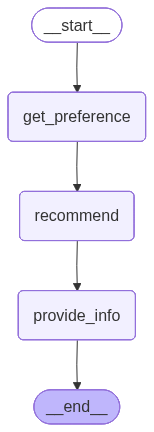

In [7]:
from langgraph.graph import StateGraph, START, END

# 그래프 빌더 생성
builder = StateGraph(MenuState)

# 노드 추가
builder.add_node("get_preference", get_user_preference)
builder.add_node("recommend", recommend_menu)
builder.add_node("provide_info", provide_menu_info)

# 엣지 추가
builder.add_edge(START, "get_preference")
builder.add_edge("get_preference", "recommend")
builder.add_edge("recommend", "provide_info")
builder.add_edge("provide_info", END)

# 그래프 컴파일
graph = builder.compile()
graph

In [8]:
#from IPython.display import Image, display

# 그래프 시각화
#display(Image(graph.get_graph().draw_mermaid_png()))

mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	get_preference(get_preference)
	recommend(recommend)
	provide_info(provide_info)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_preference;
	get_preference --> recommend;
	recommend --> provide_info;
	provide_info --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://www.mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNplkEEOwiAQRa9C6qZNrFYXLmjTlUdwp6ZBOtOSIBCKJsZ4d1tqiOiKGebBf_BMuG4hoUlnmenJYV-e1Mk1zeCYHZf0WJk6dNXa1OeMUorCDm4CO3CNsYBgQXFI4zabCAtcX6-g2jRUft9YfRctNEKhTr-bbBYYuRDv6xAu2ZwdtEie1ySOLv_lPBUcysjNz74lyl9FT3xM_JCPGsMekLSA7CYdQSElXeAWC8SlFAryHkTXO7pZbaMD_vM8nmvDuHAPWkTA9MDPdRe87JAnrzcCGprA)

In [11]:
# 그래프 실행

def print_result(result: MenuState):
    print("\n=== 결과 ===")
    print("선호도:", result['user_preference'])
    print("추천 메뉴:", result['recommended_menu'])
    print("메뉴 정보:", result['menu_info'])
    print("============\n")


# 초기 입려
inputs = {"user_preference": ""}

# 여러 번 실행하여 테스트 
for _ in range(2):
    result = graph.invoke(inputs)
    print(type(result))
    print_result(result)
    print("*"*100)
    print()

---랜덤 사용자 선호도 생성---
생성된 선호도: 채식
---메뉴 추천---
추천 메뉴: 그린 샐러드
---메뉴 정보 제공---
메뉴 정보: 신선한 유기농 채소로 만든 건강한 샐러드. 가격: 15,000원
<class 'dict'>

=== 결과 ===
선호도: 채식
추천 메뉴: 그린 샐러드
메뉴 정보: 신선한 유기농 채소로 만든 건강한 샐러드. 가격: 15,000원

****************************************************************************************************

---랜덤 사용자 선호도 생성---
생성된 선호도: 해산물
---메뉴 추천---
추천 메뉴: 랍스터 파스타
---메뉴 정보 제공---
메뉴 정보: 신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원
<class 'dict'>

=== 결과 ===
선호도: 해산물
추천 메뉴: 랍스터 파스타
메뉴 정보: 신선한 랍스터와 al dente 파스타의 조화. 가격: 28,000원

****************************************************************************************************



## 3. 조건부 엣지(Edge) : RAG 적용
- 엣지는 노드 간의 연결을 정의
- 조건부 엣지: 사용자 입력이 메뉴 관련인지 여부에 따라 다른 경로로 진행

`(1) State 정의`
- 사용자 입력이 메뉴 추천이면 벡터저장소에서 검색하여 RAG Chain을 실행하고,
- 그렇지 않은 경우에는 LLM이 답변을 생성

In [12]:
from typing import List, TypedDict

# state 스키마 
class MenuState(TypedDict):
    user_query: str
    is_menu_related: bool
    search_results: List[str]
    final_answer: str

`(2) 벡터저장소 검색 도구`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [13]:
from langchain_community.vectorstores import FAISS
from langchain_upstage import UpstageEmbeddings

embeddings_model = UpstageEmbeddings(model="solar-embedding-1-large")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "../db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

print(f" 저장된 벡터 개수: {menu_db.index.ntotal}")
print(f" 벡터 차원: {menu_db.index.d}")
print(f" 인덱스 타입: {type(menu_db.index)}")

 저장된 벡터 개수: 10
 벡터 차원: 4096
 인덱스 타입: <class 'faiss.swigfaiss_avx2.IndexFlatL2'>


`(3) 노드(Node)`

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o-mini")

from langchain_upstage import ChatUpstage

llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
)
print(llm.model_name)

solar-pro


In [15]:

def get_user_query(state: MenuState) -> MenuState:
    print('1 ==> get_user_query()')
    #user_query = input("무엇을 도와드릴까요? ")
    user_query = state['user_query']
    return {"user_query": user_query}


In [16]:

def analyze_input(state: MenuState) -> MenuState:
    print('2 ==> analyze_input()')
    analyze_template = """
    사용자의 입력을 분석하여 레스토랑 메뉴 추천이나 음식 정보에 관한 질문인지 판단하세요.

    사용자 입력: {user_query}

    레스토랑 메뉴나 음식 정보에 관한 질문이면 "True", 아니면 "False"로 답변하세요.

    답변:
    """
    analyze_prompt = ChatPromptTemplate.from_template(analyze_template)
    analyze_chain = analyze_prompt | llm | StrOutputParser()
    
    result = analyze_chain.invoke({"user_query": state['user_query']})
    print('====> result.strip().lower()', result.strip().lower())
    is_menu_related = result.strip().lower() == "true"
    
    return {"is_menu_related": is_menu_related}


In [17]:

# 'search_menu_info' 함수는 벡터 데이터베이스에서 관련 메뉴 정보를 검색합니다.
def search_menu_info(state: MenuState) -> MenuState:
    print('3 ==> search_menu_info()')
    
    # 'menu_db'에서 사용자 질의와 유사한 문서 2개를 검색합니다.
    results = menu_db.similarity_search(state['user_query'], k=2)
    
    # 검색된 문서들의 내용만 추출하여 리스트로 만듭니다.
    search_results = [doc.page_content for doc in results]
    
    # 검색 결과를 상태에 저장하여 다음 단계에 전달합니다.
    return {"search_results": search_results}

# 'generate_menu_response' 함수는 검색된 메뉴 정보를 활용하여 답변을 생성합니다.
def generate_menu_response(state: MenuState) -> MenuState:
    print('4 ==> generate_menu_response()')
    
    # 답변 생성에 사용될 프롬프트 템플릿을 정의합니다.
    response_template = """
    사용자 입력: {user_query}
    메뉴 관련 검색 결과: {search_results}

    위 정보를 바탕으로 사용자의 메뉴 관련 질문에 대한 상세한 답변을 생성하세요. 
    검색 결과의 정보를 활용하여 정확하고 유용한 정보를 제공하세요.

    답변:
    """
    
    # 템플릿을 기반으로 프롬프트 체인을 구성합니다.
    # 'response_prompt'가 LLM에 입력되고, 결과는 문자열로 파싱됩니다.
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    # 구성된 체인을 실행하여 최종 답변을 얻습니다.
    final_answer = response_chain.invoke({"user_query": state['user_query'], "search_results": state['search_results']})
    print(f"\n메뉴 어시스턴트: {final_answer}")
    
    # 생성된 답변을 상태에 저장합니다.
    return {"final_answer": final_answer}

# 'generate_general_response' 함수는 메뉴와 관련 없는 일반적인 질문에 응답합니다.
def generate_general_response(state: MenuState) -> MenuState:
    print('5 ==> generate_general_response()')
    
    # 일반적인 대화에 사용될 프롬프트 템플릿을 정의합니다.
    response_template = """
    사용자 입력: {user_query}

    위 입력은 레스토랑 메뉴나 음식과 관련이 없습니다. 
    일반적인 대화 맥락에서 적절한 답변을 생성하세요.

    답변:
    """
    
    # 템플릿을 기반으로 프롬프트 체인을 구성합니다.
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    # 체인을 실행하여 일반적인 답변을 생성합니다.
    final_answer = response_chain.invoke({"user_query": state['user_query']})
    print(f"\n일반 어시스턴트: {final_answer}")
    
    # 생성된 답변을 상태에 저장합니다.
    return {"final_answer": final_answer}

`(4) 엣지(Edge)`
* routing(분기)를 처리하는 노드

In [20]:
from typing import Literal

def decide_next_step(state: MenuState) -> Literal["search_menu_info", "generate_general_response"]:
    # 현재 상태에서 'is_menu_related' 값을 출력하여 다음 결정 과정을 로그로 남깁니다.
    print('6 Edge ==> decide_next_step() is_menu_related = ', state['is_menu_related'])
    
    # 만약 'is_menu_related'가 True이면 (질문이 메뉴 관련 질문일 때),
    # 메뉴 정보를 검색하는 노드로 이동하도록 "search_menu_info"를 반환합니다.
    if state['is_menu_related']:
        return "search_menu_info"
    
    # 그렇지 않다면 (질문이 일반적인 질문일 때),
    # 일반적인 답변을 생성하는 노드로 이동하도록 "generate_general_response"를 반환합니다.
    else:
        return "generate_general_response"

`(5) 그래프(Graph) 구성`

In [27]:
from langgraph.graph import StateGraph, START, END

# StateGraph 클래스를 사용하여 그래프를 구성합니다. 
# MenuState는 그래프가 공유하는 상태(state)의 스키마를 정의합니다.
builder = StateGraph(MenuState)

# --- 노드 추가 ---
# 각 노드는 그래프의 한 단계를 나타내며, 특정 작업을 수행합니다.
# "get_user_query": 사용자의 입력(질문)을 가져오는 노드
# MenuState 객체의 user_query 변수에 값을 저장하는 노드
builder.add_node("get_user_query", get_user_query)

# "analyze_input": 사용자 질의가 메뉴와 관련 있는지 분석하는 노드
# MenuState 객체의 is_menu_related 변수에 값을 저장하는 노드
builder.add_node("analyze_input", analyze_input)

# "search_menu_info": 메뉴 관련 질의일 경우, 벡터DB에서 정보를 검색하는 노드
# MenuState 객체의 search_results 변수에 값을 저장하는 노드
builder.add_node("search_menu_info", search_menu_info)

# "generate_menu_response": 검색된 메뉴 정보를 바탕으로 답변을 생성하는 노드
# MenuState 객체의 final_answer 변수에 값을 저장하는 노드
builder.add_node("generate_menu_response", generate_menu_response)

# "generate_general_response": 메뉴와 관련 없는 일반적인 질문에 답변하는 노드
# MenuState 객체의 final_answer 변수에 값을 저장하는 노드
builder.add_node("generate_general_response", generate_general_response)

builder.nodes

{'get_user_query': StateNodeSpec(runnable=get_user_query(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.MenuState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'analyze_input': StateNodeSpec(runnable=analyze_input(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.MenuState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'search_menu_info': StateNodeSpec(runnable=search_menu_info(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.MenuState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'generate_menu_response': StateNodeSpec(runnable=generate_menu_response(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class '__main__.MenuState'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'generate_general_respons

In [28]:

# --- 엣지(연결) 추가 ---
# 그래프의 시작점을 정의하고, 노드들을 순서대로 연결합니다.
# START에서 "get_user_query" 노드로 시작합니다.
builder.add_edge(START, "get_user_query")

# "get_user_query" 노드에서 "analyze_input" 노드로 이동합니다.
builder.add_edge("get_user_query", "analyze_input")

builder.edges


{('__start__', 'get_user_query'), ('get_user_query', 'analyze_input')}

In [29]:

# --- 조건부 엣지 추가 ---
# "analyze_input" 노드의 결과에 따라 동적으로 다음 노드를 결정합니다.
# decide_next_step 함수가 반환하는 값에 따라 흐름이 분기됩니다.
builder.add_conditional_edges(
    "analyze_input",            # 현재 노드: "analyze_input"
    decide_next_step,           # 라우팅 함수: 'decide_next_step'
    {
        # 'decide_next_step'이 "search_menu_info"를 반환하면, 해당 노드로 이동
        "search_menu_info": "search_menu_info",
        # 'decide_next_step'이 "generate_general_response"를 반환하면, 해당 노드로 이동
        "generate_general_response": "generate_general_response"
    }
)
builder.edges

{('__start__', 'get_user_query'), ('get_user_query', 'analyze_input')}

In [31]:

# --- 최종 엣지 ---
# 분기된 흐름이 최종 답변을 생성하고 종료되도록 연결합니다.
# "search_menu_info" 노드는 "generate_menu_response" 노드로 이어집니다.
builder.add_edge("search_menu_info", "generate_menu_response")

# 메뉴 관련 답변 생성 후 그래프를 종료합니다.
builder.add_edge("generate_menu_response", END)

# 일반적인 답변 생성 후 그래프를 종료합니다.
builder.add_edge("generate_general_response", END)

print(builder.edges)
# --- 그래프 컴파일 ---
# 정의된 노드와 엣지를 기반으로 실행 가능한 그래프를 최적화합니다.
graph = builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


{('__start__', 'get_user_query'), ('search_menu_info', 'generate_menu_response'), ('get_user_query', 'analyze_input'), ('generate_general_response', '__end__'), ('generate_menu_response', '__end__')}


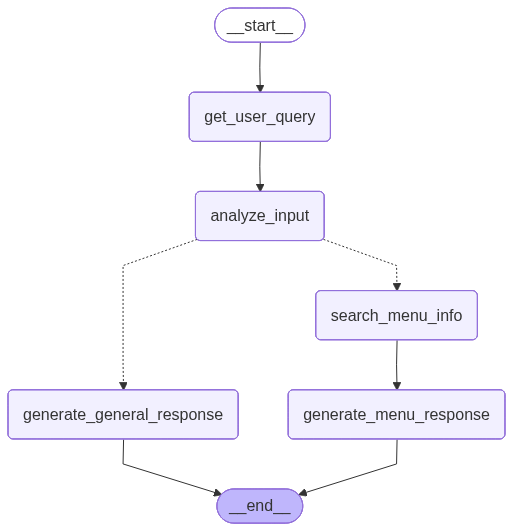

In [32]:
graph

In [33]:
#from IPython.display import Image, display

# 그래프 시각화
#display(Image(graph.get_graph().draw_mermaid_png()))
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	get_user_query(get_user_query)
	analyze_input(analyze_input)
	search_menu_info(search_menu_info)
	generate_menu_response(generate_menu_response)
	generate_general_response(generate_general_response)
	__end__([<p>__end__</p>]):::last
	__start__ --> get_user_query;
	analyze_input -.-> generate_general_response;
	analyze_input -.-> search_menu_info;
	get_user_query --> analyze_input;
	search_menu_info --> generate_menu_response;
	generate_general_response --> __end__;
	generate_menu_response --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



[Graph이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNp9U12vojAQ_Stk9gUT8GJRwWJ8uf6EfdplQypMhQQKt7TJqvG_by0uCX7cp85Mz5npOW0vkLcFAoWjZF3p_NwnqUhVlvWKSbO4v7fdbsy2H93uz4xSyivZqxvwiCrTPcrsS6M8udN0dkMwwerTGbNKdFq5k8zu98hkXmYNCm2qvHUfC7NhjkDJFA5liX3Xih7d1-UpYwjqF6THndkgHUUxCrfxKLtmg-rREMf3d85UdPIk2vHnFvVm6jvCow_Js992_ISavLL0fspXViXfWmWJdxOS99fwBMuNUf0euVMgZ7pWDq_qmv7ghAece3Ul0C-xOpaKLuZkQrAPy8L9tmN5pU40mABuV3Bvd-CHNc_BM0-3KoByVvfoQYOyYbccLqlwnBRUiQ2mQE14P04KqbgaXsfEr7ZtgCqpDVO2-lj-T3RXGJ37ipl_0YzNpdGI8rPVQgEly43tAfQCf4FGRksUBmQVbtaLcLlZeXACuljG83hN4g1ZxeEyIvHVg7MdGsyjKCQRIYt1SIIgjKLrP64fR1Y)

`(6) Graph 실행`

In [18]:
query = "레스토랑의 메뉴를 추천해 주세요"
initial_state = {'user_query':query}
graph.invoke(initial_state)

1 ==> get_user_query()
2 ==> analyze_input()
====> result.strip().lower() true
6 Edge ==> decide_next_step() is_menu_related =  True
3 ==> search_menu_info()
4 ==> generate_menu_response()

메뉴 어시스턴트: 아래는 레스토랑의 대표 메뉴 두 가지를 상세히 소개해 드리는 내용입니다. 각 메뉴의 특징, 가격, 식재료, 조리 방식 등을 참고해 취향에 맞는 메뉴를 선택해 보세요.

### 1. **시그니처 스테이크** (₩35,000)  
- **주요 식재료**:  
  - 최상급 한우 등심 (21일간 건조 숙성)  
  - 로즈메리 향이 배인 감자  
  - 아삭한 그릴드 아스파라거스  
- **특징**:  
  - 셰프의 특제 레시피로, 미디엄 레어 상태로 조리해 육즙이 풍부합니다.  
  - 레드와인 소스와 함께 제공되어 고기의 풍미를 한층 높여줍니다.  
  - 사이드 디시로 감자와 아스파라거스가 조화롭게 어우러져 균형 잡힌 한 끼를 완성합니다.  
- **추천 대상**:  
  - 고급 한우를 선호하는 분  
  - 풍부한 와인 소스와 함께 즐기는 스테이크를 원하는 분  

### 2. **트러플 리조또** (₩22,000)  
- **주요 식재료**:  
  - 이탈리아산 아르보리오 쌀 (크리미한 텍스처)  
  - 블랙 트러플 (진한 향)  
  - 24개월 숙성 파르미지아노 레지아노 치즈  
- **특징**:  
  - 주문 즉시 조리해 최상의 상태를 유지합니다.  
  - 트러플의 고급스러운 향과 치즈의 깊은 풍미가 어우러집니다.  
  - 부드러운 리조또와 트러플의 조합이 이탈리안 정취를 느끼게 해줍니다.  
- **추천 대상**:  
  - 트러플의 진한 향을 좋아하는 분  
  - 크리미한 이탈리아 요리를 즐기고 싶은 분  

### 선택 가이드  
- **고기와 와인 소스를 선호한다면** → **시

{'user_query': '레스토랑의 메뉴를 추천해 주세요',
 'is_menu_related': True,
 'search_results': ['2. 트러플 리조또\n   • 가격: ₩22,000\n   • 주요 식재료: 이탈리아산 아르보리오 쌀, 블랙 트러플, 파르미지아노 레지아노 치즈\n   • 설명: 크리미한 텍스처의 리조또에 고급 블랙 트러플을 듬뿍 얹어 풍부한 향과 맛을 즐길 수 있는 메뉴입니다. 24개월 숙성된 파르미지아노 레지아노 치즈를 사용하여 깊은 맛을 더했으며, 주문 즉시 조리하여 최상의 상태로 제공됩니다.',
  '1. 시그니처 스테이크\n   • 가격: ₩35,000\n   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스\n   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.'],
 'final_answer': '아래는 레스토랑의 대표 메뉴 두 가지를 상세히 소개해 드리는 내용입니다. 각 메뉴의 특징, 가격, 식재료, 조리 방식 등을 참고해 취향에 맞는 메뉴를 선택해 보세요.\n\n### 1. **시그니처 스테이크** (₩35,000)  \n- **주요 식재료**:  \n  - 최상급 한우 등심 (21일간 건조 숙성)  \n  - 로즈메리 향이 배인 감자  \n  - 아삭한 그릴드 아스파라거스  \n- **특징**:  \n  - 셰프의 특제 레시피로, 미디엄 레어 상태로 조리해 육즙이 풍부합니다.  \n  - 레드와인 소스와 함께 제공되어 고기의 풍미를 한층 높여줍니다.  \n  - 사이드 디시로 감자와 아스파라거스가 조화롭게 어우러져 균형 잡힌 한 끼를 완성합니다.  \n- **추천 대상**:  \n  - 고급 한우를 선호하는 분  \n  - 풍부한 와인 소스와 함께 즐기는 스테이크를 원하는 분  \

In [19]:
query = "레스토랑의 해산물 메뉴를 추천해 주세요"
initial_state = {'user_query':query}
graph.invoke(initial_state)

1 ==> get_user_query()
2 ==> analyze_input()
====> result.strip().lower() true
6 Edge ==> decide_next_step() is_menu_related =  True
3 ==> search_menu_info()
4 ==> generate_menu_response()

메뉴 어시스턴트: 해산물 메뉴를 추천해 드리기 위해 현재 레스토랑에서 제공하는 두 가지 인기 메뉴를 소개해 드리겠습니다.  

### 1. **해산물 파스타** (₩24,000)  
- **주요 재료**: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스  
- **특징**:  
  - 알 덴테(Al Dente)로 조리된 쫄깃한 링귀네 파스타에 신선한 해산물이 풍성하게 올라간 메뉴입니다.  
  - 토마토 소스의 산미와 새우, 홍합, 오징어의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 깊은 풍미를 더했습니다.  
  - 마지막에 뿌려진 파슬리가 상큼한 향을 더해 전체적인 맛의 밸런스를 완성합니다.  
- **추천 대상**:  
  - 다양한 해산물을 한 번에 즐기고 싶은 분  
  - 토마토 베이스 소스를 좋아하는 분  
  - 메인 요리로 푸짐한 식사를 원하는 분  

### 2. **연어 타르타르** (₩18,000)  
- **주요 재료**: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파  
- **특징**:  
  - 신선한 노르웨이산 생연어를 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 전채 요리입니다.  
  - 레몬 드레싱으로 상큼함을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공해 식감의 대비가 뛰어납니다.  
  - 가벼운 한 입 요리로 와인이나 샐러드와 잘 어울립니다.  
- **추천 대상**:  
  - 연어의 신선한 풍미를 즐기고 싶은 분  
  - 가벼운 전채 요리를 원하는 분  
  - 특별한 데이트나 분위기 있는 식사를 계획하는 분  

### 선택 가이드  
- **해산물의 다양성 + 푸

{'user_query': '레스토랑의 해산물 메뉴를 추천해 주세요',
 'is_menu_related': True,
 'search_results': ['6. 해산물 파스타\n   • 가격: ₩24,000\n   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스\n   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.',
  '3. 연어 타르타르\n   • 가격: ₩18,000\n   • 주요 식재료: 노르웨이산 생연어, 아보카도, 케이퍼, 적양파\n   • 설명: 신선한 노르웨이산 생연어를 곱게 다져 아보카도, 케이퍼, 적양파와 함께 섞어 만든 타르타르입니다. 레몬 드레싱으로 상큼한 맛을 더했으며, 바삭한 브리오쉬 토스트와 함께 제공됩니다. 전채요리로 완벽한 메뉴입니다.'],
 'final_answer': '해산물 메뉴를 추천해 드리기 위해 현재 레스토랑에서 제공하는 두 가지 인기 메뉴를 소개해 드리겠습니다.  \n\n### 1. **해산물 파스타** (₩24,000)  \n- **주요 재료**: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스  \n- **특징**:  \n  - 알 덴테(Al Dente)로 조리된 쫄깃한 링귀네 파스타에 신선한 해산물이 풍성하게 올라간 메뉴입니다.  \n  - 토마토 소스의 산미와 새우, 홍합, 오징어의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 깊은 풍미를 더했습니다.  \n  - 마지막에 뿌려진 파슬리가 상큼한 향을 더해 전체적인 맛의 밸런스를 완성합니다.  \n- **추천 대상**:  \n  - 다양한 해산물을 한 번에 즐기고 싶은 분  \n  - 토마토 베이스 소스를 좋아하는 분  \n  - 메인 요리로 푸짐한 식사를 원하는 분  \n\n### 2. **연어 타르타르** (₩18,000)  \n- **주요 재료**: 노르웨이산

In [34]:
query = "안녕하세요? 내일 날씨는 어떤가요?"
initial_state = {'user_query':query}
graph.invoke(initial_state)

1 ==> get_user_query()
2 ==> analyze_input()
====> result.strip().lower() false
6 Edge ==> decide_next_step() is_menu_related =  False
5 ==> generate_general_response()

일반 어시스턴트: 안녕하세요! 내일 날씨에 대해 궁금하시군요. 😊  

현재 위치 기반 날씨 정보를 제공할 수는 없지만, 일반적으로 다음과 같은 방법으로 확인하실 수 있어요:  
1. **날씨 앱** (예: 기상청, AccuWeather, The Weather Channel)  
2. **검색엔진**에서 "내일 [지역명] 날씨" 입력 (예: "내일 서울 날씨")  
3. **스마트 기기** (갤럭시/애플 워치, 구글 홈, Alexa 등)에 "내일 날씨 알려줘"라고 질문  

혹시 특정 지역을 알려주시면, 제가 최신 날씨 확인 방법을 더 자세히 안내해 드릴 수 있습니다! ☀️🌧️


{'user_query': '안녕하세요? 내일 날씨는 어떤가요?',
 'is_menu_related': False,
 'final_answer': '안녕하세요! 내일 날씨에 대해 궁금하시군요. 😊  \n\n현재 위치 기반 날씨 정보를 제공할 수는 없지만, 일반적으로 다음과 같은 방법으로 확인하실 수 있어요:  \n1. **날씨 앱** (예: 기상청, AccuWeather, The Weather Channel)  \n2. **검색엔진**에서 "내일 [지역명] 날씨" 입력 (예: "내일 서울 날씨")  \n3. **스마트 기기** (갤럭시/애플 워치, 구글 홈, Alexa 등)에 "내일 날씨 알려줘"라고 질문  \n\n혹시 특정 지역을 알려주시면, 제가 최신 날씨 확인 방법을 더 자세히 안내해 드릴 수 있습니다! ☀️🌧️'}

In [21]:
# while True:
#     initial_state = {'user_query':''}
#     graph.invoke(initial_state) 
#     continue_chat = input("다른 질문이 있으신가요? (y/n): ").lower()
#     if continue_chat != 'y':
#         print("대화를 종료합니다. 감사합니다!")
#         break